![title](dcgan.png)

In [1]:
%matplotlib inline
from sklearn.utils import shuffle
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

In [2]:
class DCGAN:
    def __init__(self, G_size, img_size, img_ch, shape_trace, kernel_size=(5, 5), strides=(2, 2)):
        self.G_size = G_size
        self.img_size = img_size
        self.img_ch = img_ch
        self.shape_trace = shape_trace
        self.kernel_size = kernel_size
        self.strides = strides
        self.build_graph()
    # end constructor


    def build_graph(self):
        self.add_input_layer()
        with tf.variable_scope('G'):
            self.add_Generator()
        with tf.variable_scope('D'):
            self.add_Discriminator()
        self.add_backward_path()
    # end method build_graph


    def add_input_layer(self):
        self.G_in = tf.placeholder(tf.float32, [None, self.G_size])
        self.X_in = tf.placeholder(tf.float32, [None, self.img_size[0], self.img_size[1], self.img_ch])
        self.train_flag = tf.placeholder(tf.bool)
    # end method input_layer


    def add_Generator(self):
        self.G_out = self.generate(self.G_in)
    # end method add_Generator


    def add_Discriminator(self):
        self.G_logits = self.discriminate(self.G_out)
        self.X_logits = self.discriminate(self.X_in, reuse=True)
        self.G_prob = tf.sigmoid(self.G_logits)
        self.X_prob = tf.sigmoid(self.X_logits)
    # end method add_Discriminator


    def add_backward_path(self):
        ones = tf.ones_like(self.G_logits)
        zeros = tf.zeros_like(self.G_logits)

        self.G_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(labels=ones, logits=self.G_logits))
        D_loss_X = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(labels=ones, logits=self.X_logits))
        D_loss_G = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(labels=zeros, logits=self.G_logits))
        self.D_loss = D_loss_X + D_loss_G

        with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS, scope='G')):
            self.G_train = tf.train.AdamOptimizer(2e-4, beta1=0.5).minimize(
                self.G_loss, var_list=tf.trainable_variables('G'))

        with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS, scope='D')):
            self.D_train = tf.train.AdamOptimizer(2e-4, beta1=0.5).minimize(
                self.D_loss, var_list=tf.trainable_variables('D'))

        self.mse = tf.reduce_mean(tf.squared_difference(self.G_out, self.X_in))
    # end method add_backward_path


    def generate(self, X):
        # for example: 100 -> (7, 7, 128) ->  (14, 14, 64) -> (28, 28, 1)
        nn = tf.layers.dense(X, np.prod(self.shape_trace[0]), self.lrelu)
        nn = tf.reshape(nn, [-1, self.shape_trace[0][0], self.shape_trace[0][1], self.shape_trace[0][2]])
        for s in self.shape_trace[1:]:
            nn = tf.layers.conv2d_transpose(nn, s[-1], self.kernel_size, strides=self.strides, padding='SAME')
            nn = tf.layers.batch_normalization(nn, training=self.train_flag, momentum=0.9)
            nn = self.lrelu(nn)
        nn = tf.layers.conv2d_transpose(nn, self.img_ch, self.kernel_size, strides=self.strides, padding='SAME')
        return tf.tanh(nn)
    # end method generate


    def discriminate(self, X, reuse=False):
        # for example: (28, 28, 1) -> (14, 14, 64) -> (7, 7, 128) -> 1
        nn = X
        for i, s in enumerate(list(reversed(self.shape_trace))):
            nn = tf.layers.conv2d(
                nn, s[2], self.kernel_size, strides=self.strides, padding='SAME', name='conv%d'%i, reuse=reuse)
            nn = tf.layers.batch_normalization(
                nn, training=self.train_flag, name='bn%d'%i, reuse=reuse, momentum=0.9)
            nn = self.lrelu(nn)
        flat = tf.reshape(nn, [-1, np.prod(self.shape_trace[0])])
        output = tf.layers.dense(flat, 1, name='out', reuse=reuse)
        return output
    # end method discriminate


    def lrelu(self, X, alpha=0.2):
        return tf.maximum(X, X * alpha)
    # end method lrelu
# end class

In [3]:
def gen_batch(arr, batch_size):
    for i in range(0, len(arr), batch_size):
        yield arr[i : i+batch_size]


def scaled(images):
    return (images.astype(np.float32) - (255./2)) / (255./2)


def select(images, labels, num):
    return np.expand_dims(images, 3)[labels == num]


def main(N_EPOCH, BATCH_SIZE, G_SIZE, DIGIT):    
    (X_train, y_train), (_, _) = tf.keras.datasets.mnist.load_data()
    X = select(scaled(X_train), y_train, DIGIT)
    
    gan = DCGAN(G_SIZE, (28, 28), 1, shape_trace=[(7, 7, 128), (14, 14, 64)])
    sess = tf.Session()
    sess.run(tf.global_variables_initializer())
    
    for i, epoch in enumerate(range(N_EPOCH)):
        X = shuffle(X)
        for step, images in enumerate(gen_batch(X, BATCH_SIZE)):
            noise = np.random.randn(len(images), G_SIZE)

            sess.run(gan.D_train, {gan.G_in: noise,
                                   gan.X_in: images,
                                   gan.train_flag: True})
            for _ in range(2):
                sess.run(gan.G_train, {gan.G_in: noise,
                                       gan.train_flag: True})

            G_loss, D_loss, D_prob, G_prob, mse = sess.run([gan.G_loss,
                                                            gan.D_loss,
                                                            gan.X_prob,
                                                            gan.G_prob,
                                                            gan.mse],
                                                           {gan.G_in: noise,
                                                            gan.X_in: images,
                                                            gan.train_flag: False})
            
            print("Epoch %d/%d | Step %d/%d" % (epoch+1, N_EPOCH, step, len(X)//BATCH_SIZE))
            print("G loss: %.4f | D loss: %.4f | D prob: %.4f | G prob: %.4f | mse: %.4f" %
                 (G_loss, D_loss, D_prob.mean(), G_prob.mean(), mse))
    
    img = sess.run(gan.G_out, {gan.G_in: noise, gan.train_flag: False})[0]
    plt.imshow(np.squeeze(img))

Epoch 1/20 | Step 0/45
G loss: 0.6765 | D loss: 1.3274 | D prob: 0.5395 | G prob: 0.5084 | mse: 0.9327
Epoch 1/20 | Step 1/45
G loss: 0.6818 | D loss: 1.2952 | D prob: 0.5541 | G prob: 0.5057 | mse: 0.9327
Epoch 1/20 | Step 2/45
G loss: 0.7082 | D loss: 1.2664 | D prob: 0.5557 | G prob: 0.4925 | mse: 0.9261
Epoch 1/20 | Step 3/45
G loss: 0.7563 | D loss: 1.2319 | D prob: 0.5503 | G prob: 0.4694 | mse: 0.9228
Epoch 1/20 | Step 4/45
G loss: 0.8145 | D loss: 1.2019 | D prob: 0.5404 | G prob: 0.4429 | mse: 0.9163
Epoch 1/20 | Step 5/45
G loss: 0.8768 | D loss: 1.1573 | D prob: 0.5392 | G prob: 0.4161 | mse: 0.9094
Epoch 1/20 | Step 6/45
G loss: 0.9453 | D loss: 1.1351 | D prob: 0.5278 | G prob: 0.3886 | mse: 0.9023
Epoch 1/20 | Step 7/45
G loss: 1.0164 | D loss: 1.0957 | D prob: 0.5270 | G prob: 0.3619 | mse: 0.8959
Epoch 1/20 | Step 8/45
G loss: 1.1062 | D loss: 1.0321 | D prob: 0.5360 | G prob: 0.3309 | mse: 0.8970
Epoch 1/20 | Step 9/45
G loss: 1.2362 | D loss: 0.9867 | D prob: 0.5307 |

Epoch 2/20 | Step 33/45
G loss: 0.9231 | D loss: 2.1715 | D prob: 0.2275 | G prob: 0.4079 | mse: 0.4183
Epoch 2/20 | Step 34/45
G loss: 0.3456 | D loss: 1.8232 | D prob: 0.6355 | G prob: 0.7138 | mse: 0.4064
Epoch 2/20 | Step 35/45
G loss: 1.2189 | D loss: 2.6039 | D prob: 0.1335 | G prob: 0.3096 | mse: 0.4177
Epoch 2/20 | Step 36/45
G loss: 0.2671 | D loss: 1.9030 | D prob: 0.7148 | G prob: 0.7706 | mse: 0.4135
Epoch 2/20 | Step 37/45
G loss: 1.2395 | D loss: 2.3602 | D prob: 0.1630 | G prob: 0.3020 | mse: 0.3976
Epoch 2/20 | Step 38/45
G loss: 0.3555 | D loss: 1.7860 | D prob: 0.6414 | G prob: 0.7079 | mse: 0.4089
Epoch 2/20 | Step 39/45
G loss: 0.8343 | D loss: 1.9974 | D prob: 0.2887 | G prob: 0.4492 | mse: 0.4097
Epoch 2/20 | Step 40/45
G loss: 0.5798 | D loss: 1.9019 | D prob: 0.4003 | G prob: 0.5691 | mse: 0.4204
Epoch 2/20 | Step 41/45
G loss: 0.6648 | D loss: 1.8713 | D prob: 0.3669 | G prob: 0.5239 | mse: 0.4163
Epoch 2/20 | Step 42/45
G loss: 0.7426 | D loss: 2.0113 | D prob

Epoch 4/20 | Step 20/45
G loss: 0.5094 | D loss: 1.4253 | D prob: 0.6444 | G prob: 0.6083 | mse: 0.4429
Epoch 4/20 | Step 21/45
G loss: 0.9364 | D loss: 1.4392 | D prob: 0.4230 | G prob: 0.4032 | mse: 0.4278
Epoch 4/20 | Step 22/45
G loss: 0.6562 | D loss: 1.4235 | D prob: 0.5304 | G prob: 0.5259 | mse: 0.4350
Epoch 4/20 | Step 23/45
G loss: 0.9067 | D loss: 1.5026 | D prob: 0.4065 | G prob: 0.4143 | mse: 0.4237
Epoch 4/20 | Step 24/45
G loss: 0.6761 | D loss: 1.4389 | D prob: 0.5090 | G prob: 0.5155 | mse: 0.4255
Epoch 4/20 | Step 25/45
G loss: 0.9070 | D loss: 1.4888 | D prob: 0.4026 | G prob: 0.4135 | mse: 0.4384
Epoch 4/20 | Step 26/45
G loss: 0.5423 | D loss: 1.4466 | D prob: 0.5909 | G prob: 0.5868 | mse: 0.4264
Epoch 4/20 | Step 27/45
G loss: 0.9437 | D loss: 1.4654 | D prob: 0.4013 | G prob: 0.3968 | mse: 0.4249
Epoch 4/20 | Step 28/45
G loss: 0.5709 | D loss: 1.3911 | D prob: 0.6046 | G prob: 0.5708 | mse: 0.4371
Epoch 4/20 | Step 29/45
G loss: 0.9680 | D loss: 1.4529 | D prob

Epoch 6/20 | Step 7/45
G loss: 0.5793 | D loss: 1.3192 | D prob: 0.6433 | G prob: 0.5684 | mse: 0.4570
Epoch 6/20 | Step 8/45
G loss: 1.0292 | D loss: 1.4203 | D prob: 0.3985 | G prob: 0.3680 | mse: 0.4562
Epoch 6/20 | Step 9/45
G loss: 0.4871 | D loss: 1.3804 | D prob: 0.6942 | G prob: 0.6218 | mse: 0.4625
Epoch 6/20 | Step 10/45
G loss: 1.1440 | D loss: 1.3763 | D prob: 0.3976 | G prob: 0.3294 | mse: 0.4554
Epoch 6/20 | Step 11/45
G loss: 0.5703 | D loss: 1.2918 | D prob: 0.6650 | G prob: 0.5727 | mse: 0.4604
Epoch 6/20 | Step 12/45
G loss: 1.0110 | D loss: 1.3580 | D prob: 0.4355 | G prob: 0.3759 | mse: 0.4745
Epoch 6/20 | Step 13/45
G loss: 0.7468 | D loss: 1.2743 | D prob: 0.5605 | G prob: 0.4843 | mse: 0.4598
Epoch 6/20 | Step 14/45
G loss: 0.6747 | D loss: 1.2919 | D prob: 0.5853 | G prob: 0.5167 | mse: 0.4503
Epoch 6/20 | Step 15/45
G loss: 0.9893 | D loss: 1.3972 | D prob: 0.4243 | G prob: 0.3831 | mse: 0.4430
Epoch 6/20 | Step 16/45
G loss: 0.6638 | D loss: 1.2640 | D prob: 0

Epoch 7/20 | Step 40/45
G loss: 0.8729 | D loss: 1.2208 | D prob: 0.5374 | G prob: 0.4286 | mse: 0.4522
Epoch 7/20 | Step 41/45
G loss: 0.7124 | D loss: 1.2757 | D prob: 0.5887 | G prob: 0.4993 | mse: 0.4681
Epoch 7/20 | Step 42/45
G loss: 0.9752 | D loss: 1.2521 | D prob: 0.4877 | G prob: 0.3879 | mse: 0.4654
Epoch 7/20 | Step 43/45
G loss: 0.6746 | D loss: 1.2161 | D prob: 0.6370 | G prob: 0.5178 | mse: 0.4496
Epoch 7/20 | Step 44/45
G loss: 1.3274 | D loss: 1.4176 | D prob: 0.3557 | G prob: 0.2767 | mse: 0.4542
Epoch 7/20 | Step 45/45
G loss: 0.4095 | D loss: 1.4307 | D prob: 0.7477 | G prob: 0.6684 | mse: 0.4750
Epoch 8/20 | Step 0/45
G loss: 1.5660 | D loss: 1.6927 | D prob: 0.2601 | G prob: 0.2259 | mse: 0.4733
Epoch 8/20 | Step 1/45
G loss: 0.3315 | D loss: 1.5273 | D prob: 0.8112 | G prob: 0.7215 | mse: 0.4581
Epoch 8/20 | Step 2/45
G loss: 1.1671 | D loss: 1.3356 | D prob: 0.4156 | G prob: 0.3266 | mse: 0.4813
Epoch 8/20 | Step 3/45
G loss: 0.5769 | D loss: 1.2514 | D prob: 0.

Epoch 9/20 | Step 27/45
G loss: 1.2707 | D loss: 1.3532 | D prob: 0.3864 | G prob: 0.2929 | mse: 0.4654
Epoch 9/20 | Step 28/45
G loss: 0.5761 | D loss: 1.2658 | D prob: 0.6823 | G prob: 0.5712 | mse: 0.4740
Epoch 9/20 | Step 29/45
G loss: 1.0867 | D loss: 1.2650 | D prob: 0.4514 | G prob: 0.3482 | mse: 0.4588
Epoch 9/20 | Step 30/45
G loss: 0.7119 | D loss: 1.2061 | D prob: 0.6235 | G prob: 0.5020 | mse: 0.4419
Epoch 9/20 | Step 31/45
G loss: 0.8327 | D loss: 1.2240 | D prob: 0.5502 | G prob: 0.4446 | mse: 0.4666
Epoch 9/20 | Step 32/45
G loss: 0.9670 | D loss: 1.1840 | D prob: 0.5249 | G prob: 0.3895 | mse: 0.4700
Epoch 9/20 | Step 33/45
G loss: 0.7026 | D loss: 1.2126 | D prob: 0.6173 | G prob: 0.5027 | mse: 0.4639
Epoch 9/20 | Step 34/45
G loss: 1.1146 | D loss: 1.3436 | D prob: 0.4155 | G prob: 0.3381 | mse: 0.4447
Epoch 9/20 | Step 35/45
G loss: 0.5337 | D loss: 1.2942 | D prob: 0.7031 | G prob: 0.5941 | mse: 0.4607
Epoch 9/20 | Step 36/45
G loss: 1.0966 | D loss: 1.3531 | D prob

Epoch 11/20 | Step 14/45
G loss: 0.6269 | D loss: 1.2659 | D prob: 0.6519 | G prob: 0.5460 | mse: 0.4580
Epoch 11/20 | Step 15/45
G loss: 0.6732 | D loss: 1.2371 | D prob: 0.6208 | G prob: 0.5186 | mse: 0.4614
Epoch 11/20 | Step 16/45
G loss: 0.9651 | D loss: 1.2632 | D prob: 0.4838 | G prob: 0.3896 | mse: 0.4734
Epoch 11/20 | Step 17/45
G loss: 0.6231 | D loss: 1.2560 | D prob: 0.6505 | G prob: 0.5454 | mse: 0.4558
Epoch 11/20 | Step 18/45
G loss: 1.0250 | D loss: 1.2588 | D prob: 0.4781 | G prob: 0.3731 | mse: 0.4625
Epoch 11/20 | Step 19/45
G loss: 0.6924 | D loss: 1.1909 | D prob: 0.6445 | G prob: 0.5100 | mse: 0.4379
Epoch 11/20 | Step 20/45
G loss: 1.1158 | D loss: 1.2489 | D prob: 0.4626 | G prob: 0.3432 | mse: 0.4591
Epoch 11/20 | Step 21/45
G loss: 0.5573 | D loss: 1.2709 | D prob: 0.7006 | G prob: 0.5828 | mse: 0.4456
Epoch 11/20 | Step 22/45
G loss: 1.3056 | D loss: 1.3697 | D prob: 0.3831 | G prob: 0.2849 | mse: 0.4512
Epoch 11/20 | Step 23/45
G loss: 0.4682 | D loss: 1.347

Epoch 13/20 | Step 1/45
G loss: 0.3885 | D loss: 1.4658 | D prob: 0.7829 | G prob: 0.6868 | mse: 0.4480
Epoch 13/20 | Step 2/45
G loss: 0.8705 | D loss: 1.3305 | D prob: 0.5004 | G prob: 0.4350 | mse: 0.4638
Epoch 13/20 | Step 3/45
G loss: 0.7790 | D loss: 1.2889 | D prob: 0.5410 | G prob: 0.4679 | mse: 0.4404
Epoch 13/20 | Step 4/45
G loss: 0.5162 | D loss: 1.3474 | D prob: 0.6886 | G prob: 0.6047 | mse: 0.4415
Epoch 13/20 | Step 5/45
G loss: 1.2559 | D loss: 1.4264 | D prob: 0.3732 | G prob: 0.2988 | mse: 0.4512
Epoch 13/20 | Step 6/45
G loss: 0.3565 | D loss: 1.5119 | D prob: 0.7876 | G prob: 0.7063 | mse: 0.4519
Epoch 13/20 | Step 7/45
G loss: 1.1621 | D loss: 1.3691 | D prob: 0.3939 | G prob: 0.3234 | mse: 0.4555
Epoch 13/20 | Step 8/45
G loss: 0.4120 | D loss: 1.4282 | D prob: 0.7515 | G prob: 0.6677 | mse: 0.4499
Epoch 13/20 | Step 9/45
G loss: 0.9847 | D loss: 1.2682 | D prob: 0.4742 | G prob: 0.3839 | mse: 0.4478
Epoch 13/20 | Step 10/45
G loss: 0.6903 | D loss: 1.2562 | D pro

Epoch 14/20 | Step 34/45
G loss: 1.2280 | D loss: 1.5265 | D prob: 0.3335 | G prob: 0.3060 | mse: 0.4401
Epoch 14/20 | Step 35/45
G loss: 0.4271 | D loss: 1.4568 | D prob: 0.7148 | G prob: 0.6586 | mse: 0.4414
Epoch 14/20 | Step 36/45
G loss: 1.0410 | D loss: 1.3950 | D prob: 0.4181 | G prob: 0.3658 | mse: 0.4568
Epoch 14/20 | Step 37/45
G loss: 0.5042 | D loss: 1.3768 | D prob: 0.6755 | G prob: 0.6115 | mse: 0.4742
Epoch 14/20 | Step 38/45
G loss: 0.9629 | D loss: 1.3195 | D prob: 0.4578 | G prob: 0.3920 | mse: 0.4661
Epoch 14/20 | Step 39/45
G loss: 0.5403 | D loss: 1.3643 | D prob: 0.6565 | G prob: 0.5906 | mse: 0.4633
Epoch 14/20 | Step 40/45
G loss: 0.8281 | D loss: 1.2667 | D prob: 0.5368 | G prob: 0.4483 | mse: 0.4635
Epoch 14/20 | Step 41/45
G loss: 0.6539 | D loss: 1.3027 | D prob: 0.6128 | G prob: 0.5313 | mse: 0.4572
Epoch 14/20 | Step 42/45
G loss: 0.8803 | D loss: 1.2752 | D prob: 0.5118 | G prob: 0.4271 | mse: 0.4610
Epoch 14/20 | Step 43/45
G loss: 0.8308 | D loss: 1.264

Epoch 16/20 | Step 21/45
G loss: 0.7965 | D loss: 1.3397 | D prob: 0.5149 | G prob: 0.4624 | mse: 0.4566
Epoch 16/20 | Step 22/45
G loss: 0.7684 | D loss: 1.3079 | D prob: 0.5344 | G prob: 0.4735 | mse: 0.4534
Epoch 16/20 | Step 23/45
G loss: 0.8418 | D loss: 1.3763 | D prob: 0.4737 | G prob: 0.4416 | mse: 0.4609
Epoch 16/20 | Step 24/45
G loss: 0.6839 | D loss: 1.3341 | D prob: 0.5629 | G prob: 0.5119 | mse: 0.4541
Epoch 16/20 | Step 25/45
G loss: 1.1414 | D loss: 1.3926 | D prob: 0.3978 | G prob: 0.3325 | mse: 0.4693
Epoch 16/20 | Step 26/45
G loss: 0.2794 | D loss: 1.6542 | D prob: 0.8286 | G prob: 0.7596 | mse: 0.4562
Epoch 16/20 | Step 27/45
G loss: 1.6012 | D loss: 1.7676 | D prob: 0.2414 | G prob: 0.2207 | mse: 0.4814
Epoch 16/20 | Step 28/45
G loss: 0.2552 | D loss: 1.7614 | D prob: 0.8326 | G prob: 0.7793 | mse: 0.4807
Epoch 16/20 | Step 29/45
G loss: 0.9630 | D loss: 1.3829 | D prob: 0.4435 | G prob: 0.3956 | mse: 0.4553
Epoch 16/20 | Step 30/45
G loss: 0.5486 | D loss: 1.357

Epoch 18/20 | Step 8/45
G loss: 0.6328 | D loss: 1.3116 | D prob: 0.6042 | G prob: 0.5378 | mse: 0.4614
Epoch 18/20 | Step 9/45
G loss: 0.7278 | D loss: 1.2953 | D prob: 0.5635 | G prob: 0.4932 | mse: 0.4457
Epoch 18/20 | Step 10/45
G loss: 0.7384 | D loss: 1.3391 | D prob: 0.5381 | G prob: 0.4884 | mse: 0.4619
Epoch 18/20 | Step 11/45
G loss: 0.4992 | D loss: 1.4197 | D prob: 0.6529 | G prob: 0.6141 | mse: 0.4565
Epoch 18/20 | Step 12/45
G loss: 1.3567 | D loss: 1.5563 | D prob: 0.3137 | G prob: 0.2706 | mse: 0.4500
Epoch 18/20 | Step 13/45
G loss: 0.2839 | D loss: 1.6629 | D prob: 0.8213 | G prob: 0.7571 | mse: 0.4395
Epoch 18/20 | Step 14/45
G loss: 1.2379 | D loss: 1.5843 | D prob: 0.3166 | G prob: 0.3034 | mse: 0.4587
Epoch 18/20 | Step 15/45
G loss: 0.4556 | D loss: 1.4214 | D prob: 0.6984 | G prob: 0.6402 | mse: 0.4485
Epoch 18/20 | Step 16/45
G loss: 0.8217 | D loss: 1.3094 | D prob: 0.5164 | G prob: 0.4528 | mse: 0.4536
Epoch 18/20 | Step 17/45
G loss: 0.9182 | D loss: 1.3435 

Epoch 19/20 | Step 41/45
G loss: 1.2926 | D loss: 1.5539 | D prob: 0.3132 | G prob: 0.2868 | mse: 0.4657
Epoch 19/20 | Step 42/45
G loss: 0.2742 | D loss: 1.6883 | D prob: 0.8238 | G prob: 0.7638 | mse: 0.4541
Epoch 19/20 | Step 43/45
G loss: 1.3055 | D loss: 1.5327 | D prob: 0.3292 | G prob: 0.2877 | mse: 0.4561
Epoch 19/20 | Step 44/45
G loss: 0.5113 | D loss: 1.3884 | D prob: 0.6573 | G prob: 0.6059 | mse: 0.4602
Epoch 19/20 | Step 45/45
G loss: 1.0866 | D loss: 1.4369 | D prob: 0.3894 | G prob: 0.3466 | mse: 0.4689
Epoch 20/20 | Step 0/45
G loss: 0.7646 | D loss: 1.3034 | D prob: 0.5426 | G prob: 0.4749 | mse: 0.4556
Epoch 20/20 | Step 1/45
G loss: 0.9904 | D loss: 1.3437 | D prob: 0.4427 | G prob: 0.3820 | mse: 0.4568
Epoch 20/20 | Step 2/45
G loss: 0.9688 | D loss: 1.3007 | D prob: 0.4717 | G prob: 0.3926 | mse: 0.4476
Epoch 20/20 | Step 3/45
G loss: 0.4643 | D loss: 1.3923 | D prob: 0.7078 | G prob: 0.6347 | mse: 0.4483
Epoch 20/20 | Step 4/45
G loss: 1.2602 | D loss: 1.6170 | D

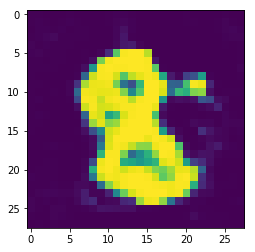

In [4]:
main(N_EPOCH = 20,
     BATCH_SIZE = 128,
     G_SIZE = 100,
     DIGIT = 8)